In [1]:
import numpy as np
import pandas as pd
import random as rd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import warnings
warnings.filterwarnings("ignore")

In [2]:
sales = pd.read_csv('../input/sales_train.csv')
item_cat = pd.read_csv('../input/item_categories.csv')
item = pd.read_csv('../input/items.csv')
sub = pd.read_csv('../input/sample_submission.csv')
shops = pd.read_csv('../input/shops.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
test.tail()

,ID,shop_id,item_id
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


In [5]:
len(test['item_id'].unique())

5100

In [11]:
len(sales['shop_id'].unique())

60

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
len(test['shop_id'].unique())

42

In [6]:
len(sales['item_id'].unique())

21807

In [14]:
sales['date_block_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [5]:
sales.date

0          02.01.2013
1          03.01.2013
2          05.01.2013
3          06.01.2013
4          15.01.2013
              ...    
2935844    10.10.2015
2935845    09.10.2015
2935846    14.10.2015
2935847    22.10.2015
2935848    03.10.2015
Name: date, Length: 2935849, dtype: object

In [3]:
sales.date = sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

In [12]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [13]:
monthly_sales = sales.groupby(['date_block_num',
                               'shop_id', 
                               "item_id"],as_index=False)["date", 
                                           "item_price","item_cnt_day"].agg({"date":['min','max'],
                                                                            "item_price":"mean","item_cnt_day":"sum"})

In [16]:
monthly_sales.head(2000)

date_block_num shop_id item_id       date            item_price  \
                                           min        max       mean   
0                 0       0      32 2013-01-03 2013-01-31      221.0   
1                 0       0      33 2013-01-03 2013-01-28      347.0   
2                 0       0      35 2013-01-31 2013-01-31      247.0   
3                 0       0      43 2013-01-31 2013-01-31      221.0   
4                 0       0      51 2013-01-13 2013-01-31      128.5   
...             ...     ...     ...        ...        ...        ...   
1995              0       0   18358 2013-01-22 2013-01-22      125.0   
1996              0       0   18361 2013-01-27 2013-01-27      170.0   
1997              0       0   18364 2013-01-09 2013-01-25      110.0   
1998              0       0   18376 2013-01-23 2013-01-23      161.0   
1999              0       0   18378 2013-01-28 2013-01-28      110.0   

     item_cnt_day  
              sum  
0             6.0  
1             3.0  
2             1.0  
3             1.0  
4             2.0  
...           ...  
1995          1.0  
1996          1.0  
1997          3.0  
1998          1.0  
1999          1.0  

[2000 rows x 7 columns]

In [6]:
monthly_sales.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1609124 entries, (0, 0, 32) to (33, 59, 22102)
Data columns (total 4 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   (date, min)          1609124 non-null  datetime64[ns]
 1   (date, max)          1609124 non-null  datetime64[ns]
 2   (item_price, mean)   1609124 non-null  float64       
 3   (item_cnt_day, sum)  1609124 non-null  float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 55.4 MB


In [17]:
x = item.groupby(['item_category_id']).count()
x = x.sort_values(by='item_id', ascending=False)
x=x.iloc[0:10].reset_index()



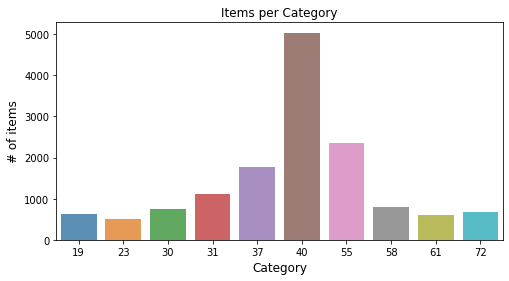

In [18]:
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel("# of items", fontsize=12)
plt.xlabel("Category", fontsize=12)
plt.show()

In [19]:
x

,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790
5,30,756,756
6,72,666,666
7,19,628,628
8,61,598,598
9,23,501,501


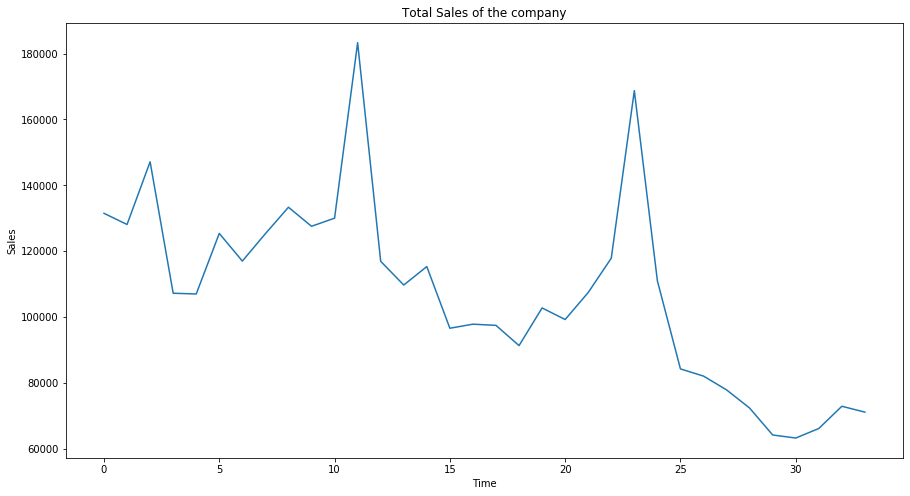

In [21]:
ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype("float")
plt.figure(figsize=(15,8))
plt.title("Total Sales of the company")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.plot(ts)